In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **어텐션의 구조**

seq2seq를 한층 더 강력하게 하는 **어텐션** 이라는 메커니즘 덕분에 seq2seq는 (인간처럼) 필요한 정보에만 '주목'할 수 있게 된다. 또한 지금까지의 seq2seq가 안고 있던 문제도 해결할 수 있다.

지금까지의 seq2seq 개선은 '작은 개선'이었던것에 반해, 어텐션 기술은 seq2seq가 안고 있던 근본적인 문제를 해결하는 '큰 개선'이다.

## **seq2seq의 문제점**

seq2seq에서 Encoder의 출력은 '고정 길이의 벡터' 였는데, 이 '고정 길이'라는 데에 큰 문제가 잠재해 있다. 아무리 긴 문장이 입력되더라도, 항상 똑같은 길이의 벡터에 밀어 넣어야 한다는 것이다.

억지로 고정 길이의 벡터로 밀어 넣는 것이므로 필요한 정보가 벡터에 다 담기지 못하게 될 수도 있다.

## **Encoder 개선**

우리는 LSTM 계층의 마지막 은닉 상태만을 Decoder에 전달 했지만, Encoder 출력의 길이는 입력 문장의 길이에 따라 바꿔주는게 좋다. 이 점이 Encoder의 개선 포인트이다. 구체적으로, 시각별 LSTM 계층의 은닉 상태 벡터를 모두 이용하는 것이다. 다음 그림을 참고하자.

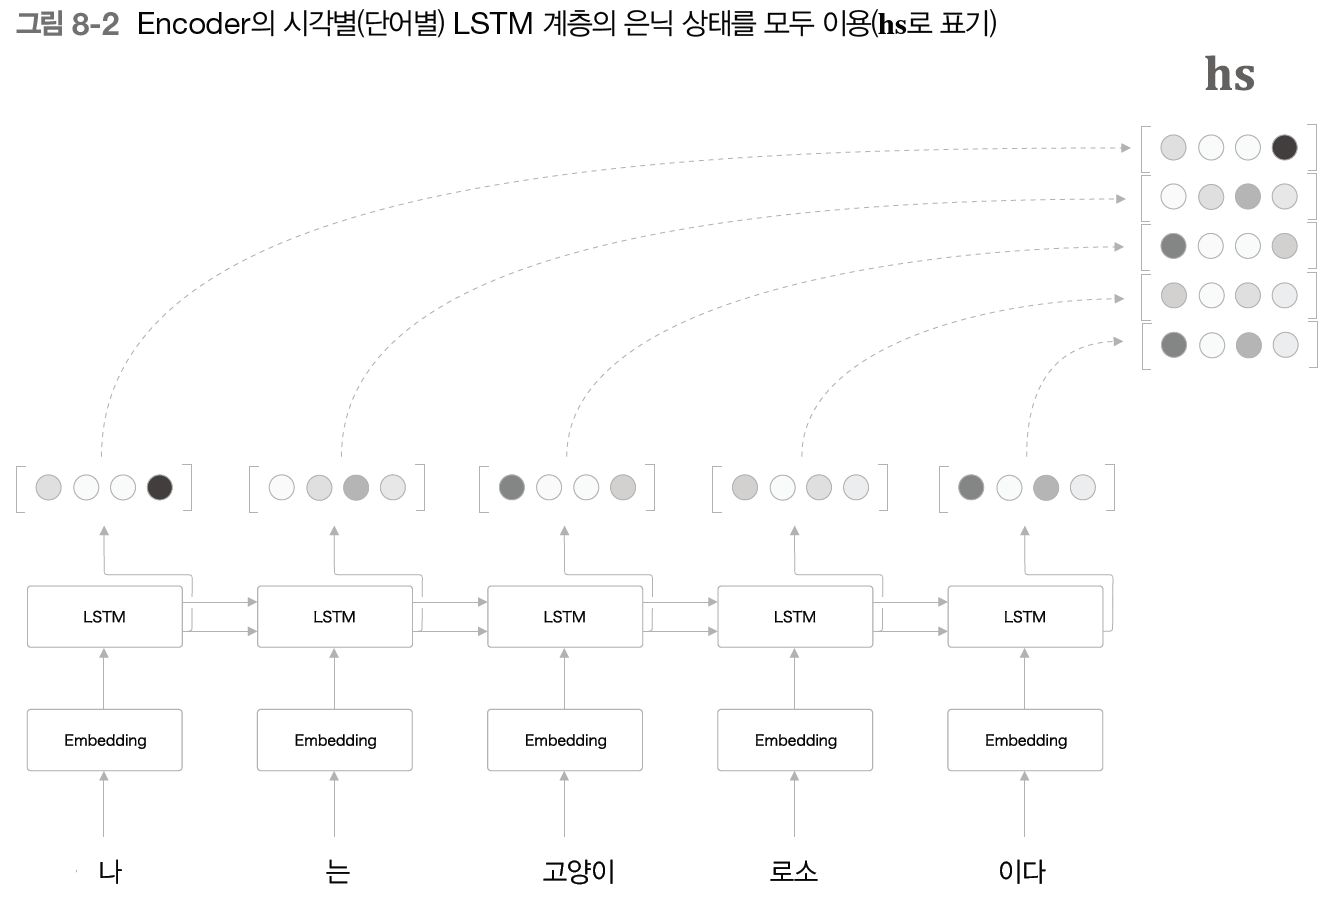

그림 처럼 각 시각(단어)의 은닉 상태 벡터를 모두 이용하면 입력된 단어와 같은 수의 벡터를 얻을 수 있다. 이것으로 Encoder는 '하나의 고정 길이 벡터'라는 제약으로부터 해방된다.

또한 각 시각의 은닉 상태에는 직전에 입력된 단어에 대한 정보가 많이 포함되어 있다. 

이제, 이 Encoder의 출력을 Decoder로 어떻게 요리하냐에 대해 논해보자.

## **Decoder 개선-1**

앞 장에서의 가장 단순한 seq2seq에서는 Encoder의 LSTM 계층의 '마지막' 은닉 상태를 Decoder의 LSTM 계층의 '첫'은닉 상태로 설정하였다. 우리는 앞으로 이 은닉 상태를 마지막 줄만 빼내어 Decoder에 전달하는 것이 아닌 전부를 활용할 수 있도록 Decoder를 개선할 것이다.

또한 앞으로 우리의 목표는 '도착의 단어'와 대응 관계에 있는 '출발어 단어'의 정보를 골라내는 것, 그리고 그 정보를 이용하여 번역을 수행하는 것이다. 다시 말해, 필요한 정보에만 주목하여 그 정보로부터 시계열 변환을 수행하는 것이 목표이다. 이 구조를 어텐션이라 부르며, 이 기술은 단어의 대응 관계를 나타내는 정보인 **얼라이먼트**라는 아이디어를 seq2seq에 자동으로 도입하는 데 성공했다.

우리가 구현하고자 하는 신경망의 계층 구선은 다음과 같다.

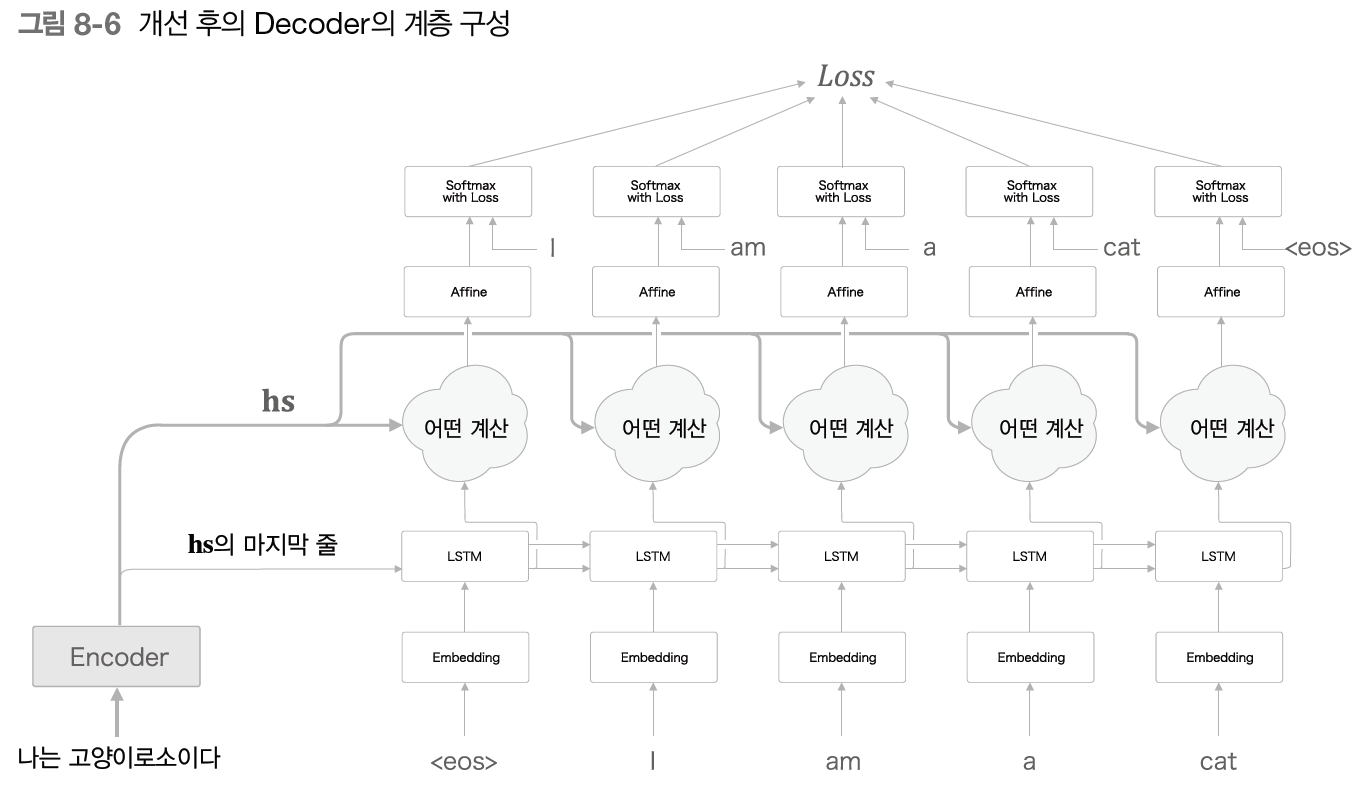

위 그림의 신경망으로 우리가 하고 싶은 일은 단어들의 얼라인먼트 추출이다. 각 시각에서 Decoder에 입력된 단어와 대응 관계인 단어의 벡터를 $hs$에서 골라내겠다는 뜻이다. 예컨대 그림에서는 Decoder가 "I"를 출력할 때, $hs$에서 "나"에 대응하는 벡터를 선택하면 된다.

이러한 '선택'작업을 '어떤 계산'으로 해내겠다는 것인데, 선택하는 작업(여러 대상으로부터 몇 개를 선택하는 작업)은 미분할 수 없다는 문제가 생긴다. 따라서 오차역전파법을 사용할 수 없다.

'선택하다'라는 작업을 미분 가능한 연산으로 대체할 수 있는 아이디어란 바로 '하나를 선택'하는게 아니라, '모든 것을 선택'한다는 것이다. 그리고 각 단어의 중요도(기여도)를 나타내는 '가중치'를 별도로 계산한다.

그림을 예로들면 다음과 같다.

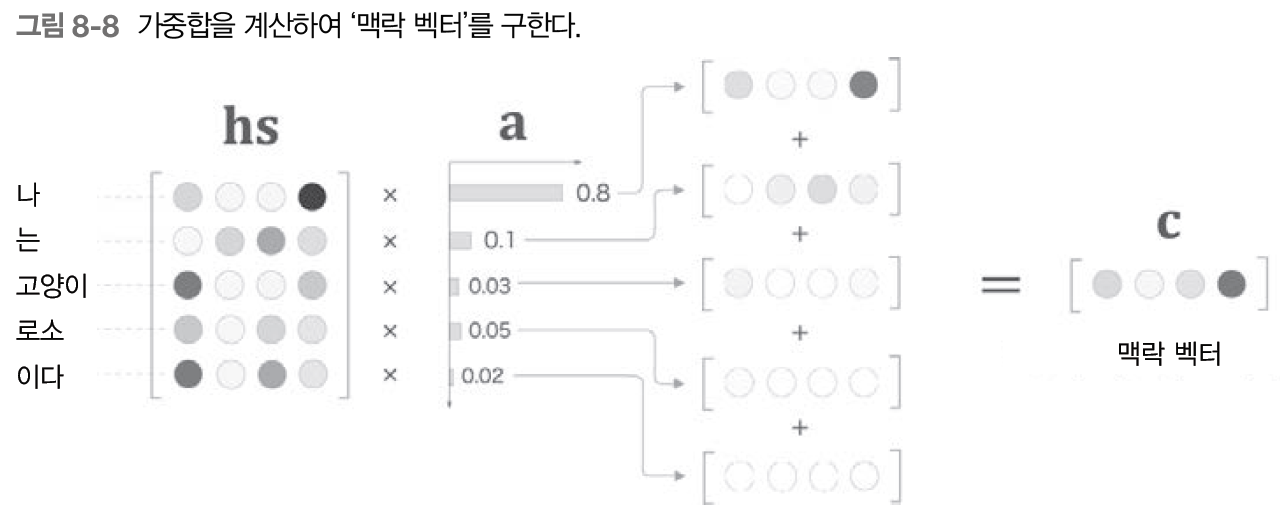

단어 벡터의 가중합을 '맥락 벡터'라고 하는데, 여기서 맥락 벡터 $c$에는 "나" 벡터의 성분이 많이 포함되어 있는 것이다. 맥락 벡터 $c$에는 현 시각의 변환(번역)을 수행하는데 필요한 정보가 담겨 있다. 정확히 말하면, 그렇게 되도록 데이터로부터 학습한다.

여기까지의 이야기를 코드로 살펴보자.

In [2]:
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis=1)
print(ar.shape)

(5, 4)


In [3]:
t = hs * ar
print(t.shape)

(5, 4)


In [4]:
c = np.sum(t, axis=0)
print(c.shape)

(4,)


In [5]:
# 미니배치 처리용 가중합 구현

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
# ar = a.reshape(N, T, 1) # 브로드캐스트를 사용하는 경우

t = hs * ar
print(t.shape)

(10, 5, 4)


In [6]:
c = np.sum(t, axis=1)
print(c.shape)

(10, 4)


가중합의 계산그래프를 그림으로 나타내면 다음과 같다.

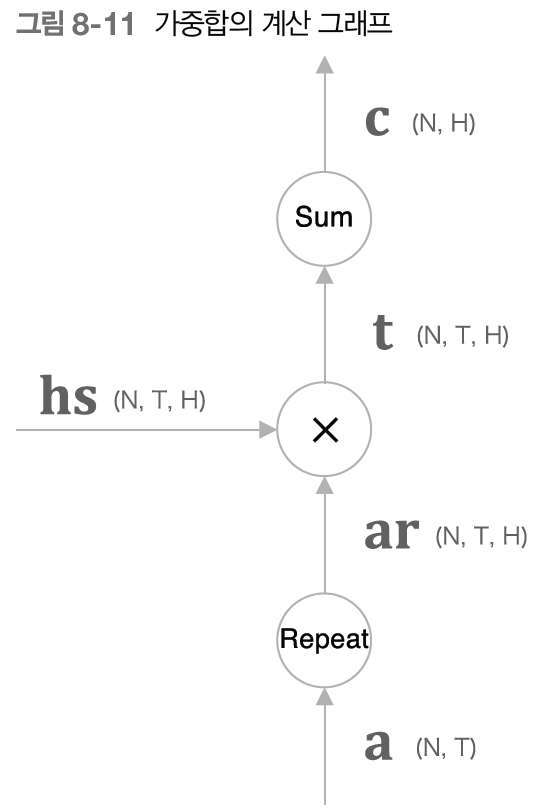

위 그림의 계산 그래프를 계층으로 구현해보자.

In [7]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape

        dt = dc.reshape(N, 1, H).repeat(T, axis=1)  # sum의 역전파는 repeat임을 학습하였음.
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)        # repeat의 역전파

        return dhs, da

## **Decoder 개선-2**

각 단어의 중요도를 나타내는 가중치 $a$를 데이터로부터 자동으로 학습할 수 있는 방법을 살펴보자.

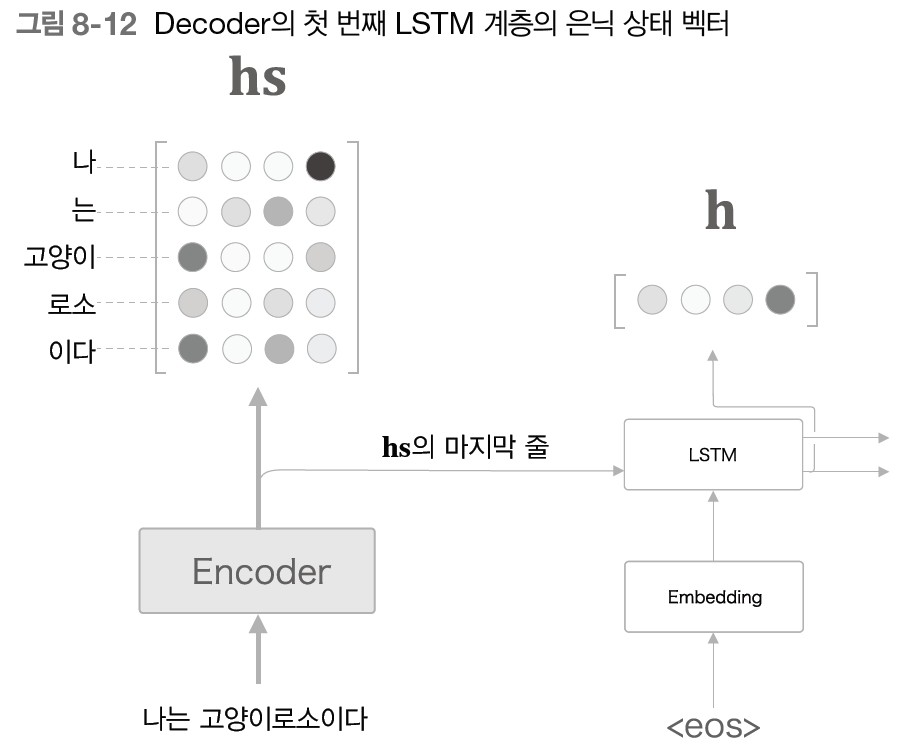

우리의 목표는 $h$가 $hs$의 각 단어 벡터와 얼마나 '비슷한가'를 수치로 나타내는 것이다. 방법은 여러가지가 있지만, 가장 단순한 방법인 벡터의 '내적'을 이용하려고 한다.

내적의 직관적인 의미는 '두 벡터가 얼마나 같은 방향을 향하고 있는가' 이다. 따라서 두 벡터의 '유사도'를 표현하는 척도로 내적을 이용하는 것은 자연스러운 선택이다.

내적을 이용한 벡터 사이의 유사도 산출할 때까지의 처리는 다음과 같다.

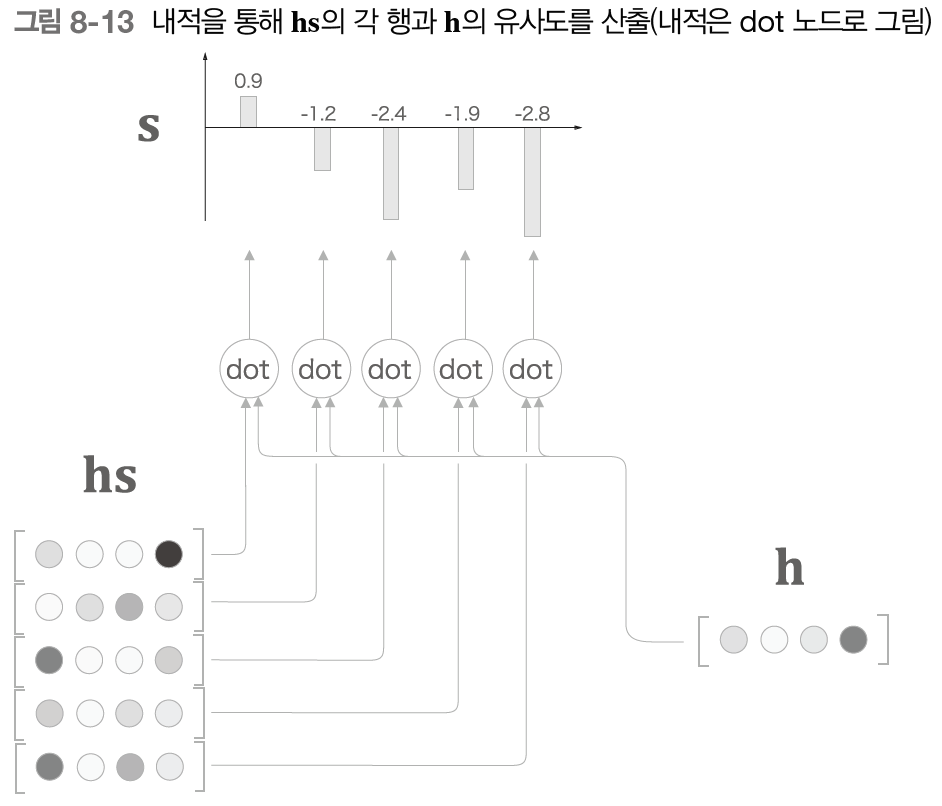

$s$는 내적을 이용한 유사도의 결과이고, 정규화하기 전의 값이며 '점수(score)' 라고도 한다. 계속해서 $s$를 정규화하기 위해서는 일반적으로 소프트맥스 함수를 적용한다.

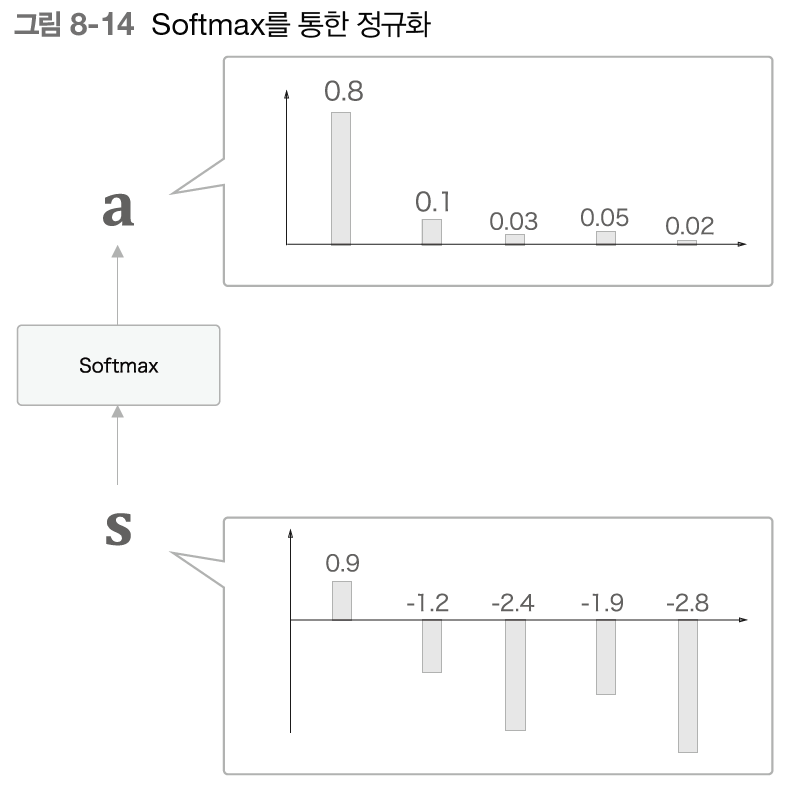

지금까지의 과정을 코드로 살펴보면 다음과 같다.

In [8]:
path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝2/deep-learning-from-scratch-2-master'
import sys
sys.path.append(path)
from common.layers import Softmax

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)
# hr = h.reshape(N, 1, H)       # 브로드캐스트를 사용하는 경우

t = hs * hr
print(t.shape)

(10, 5, 4)


In [9]:
s = np.sum(t, axis=2)
print(s.shape)

(10, 5)


In [10]:
softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5)


지금까지의 과정을 계산 그래프로 확인하자.

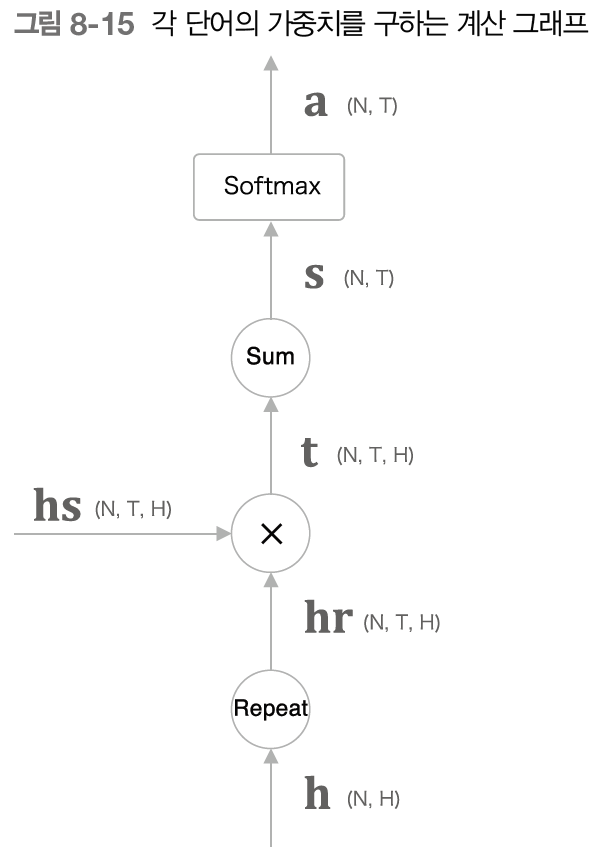

이 계산 그래프를 AttentionWeight 클래스로 구현할것이다.

In [11]:
from common.np import *  # import numpy as np
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

## **Decoder 개선-2**

앞서 구현한 Attention Weight 계층과 Weight Sum 계층을 하나로 결합하면 다음 그림과 같다.

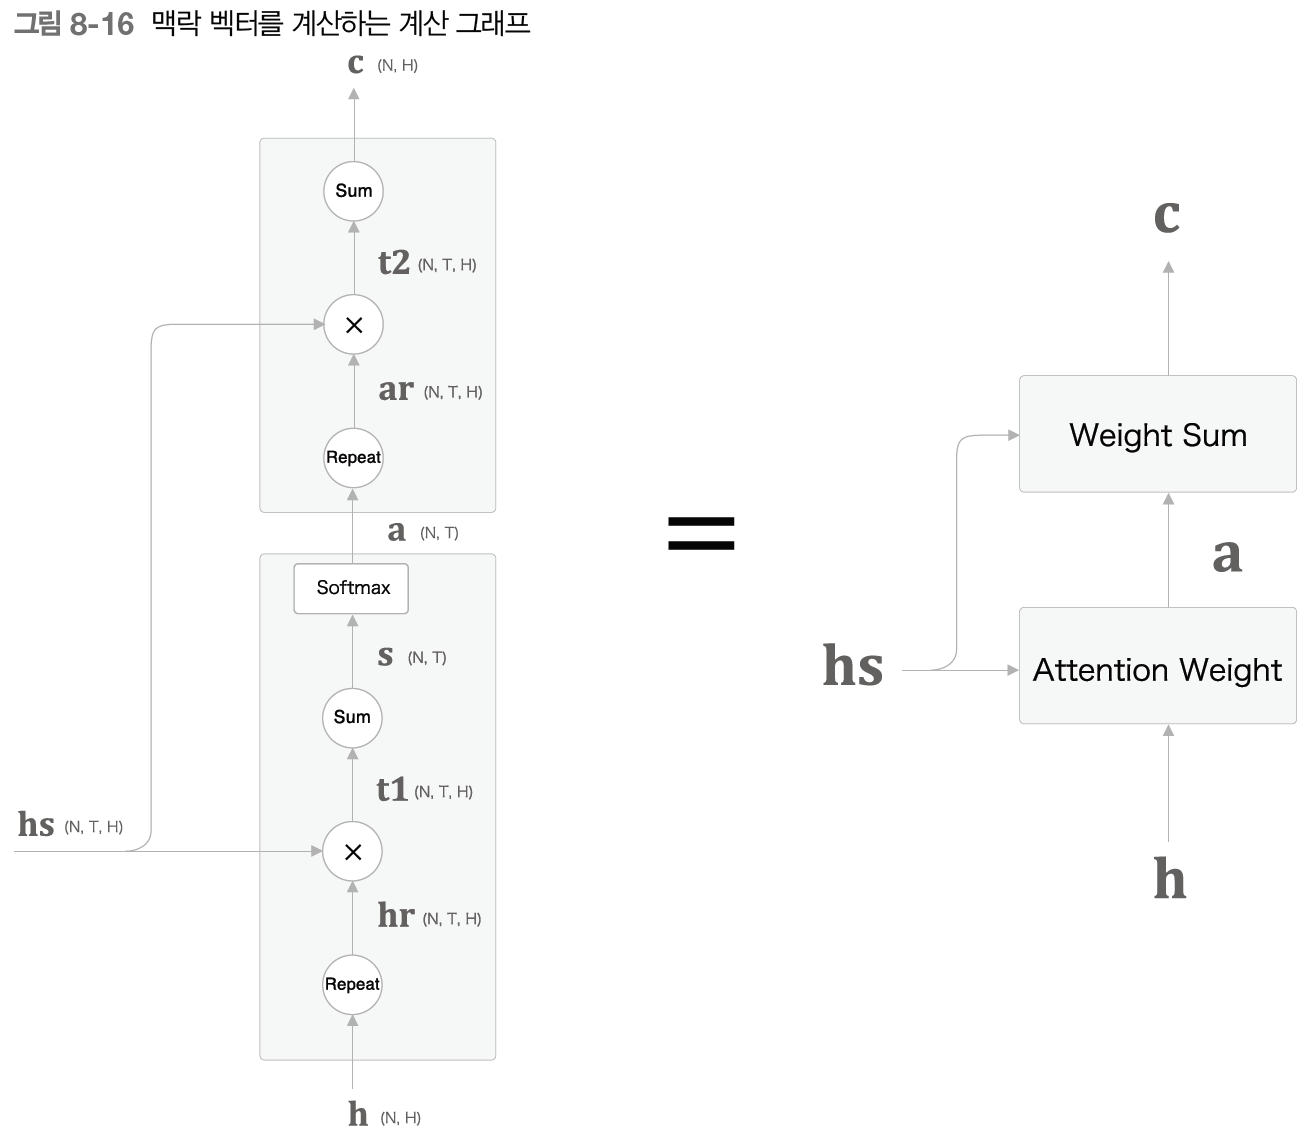

이 그림이 맥락 벡터를 구하는 계산 그래프의 전체 모습이다. 위 그림의 오른쪽 계산 그래프를 Attention 계층으로 정리한다(Weight Sum 계층과 Attention Weight 계층을 결합한다). 그러한 Attention 계층을 구현한 코드는 다음과 같다.

In [12]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

앞 장의 Decoder와 Attention이 추가된 Decoder의 비교는 다음과 같다.

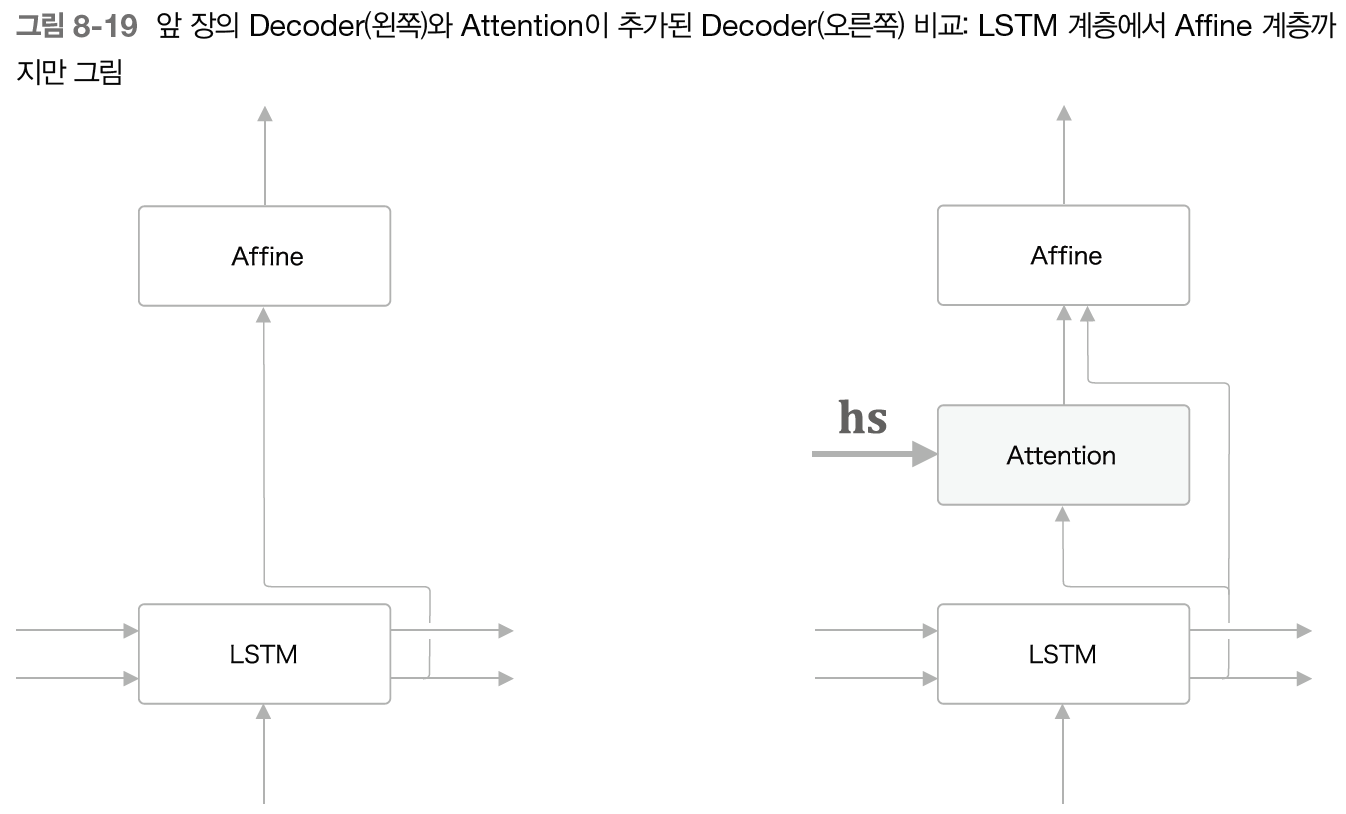

오른쪽은 Decoder에 Attention 계층이 구한 맥락 벡터 정보를 '추가'한 것으로 생각할 수 있다. Affine 계층에는 기존과 마찬가지로 LSTM 계층의 은닉 상태 벡터를 주고, 여기에 더해 Attention 계층의 맥락 벡터까지 입력하는 것이다.

마지막으로 시계열 방향으로 펼쳐진 다수의 Attention 계층을 Time Attention 계층으로 모아 구현한다.

In [13]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

# **어텐션을 갖춘 seq2seq 구현**

앞 절 에서 구현한 Ateention 계층으로 이번 절에서는 '어텐션을 갖춘 seq2seq'을 구현할것이다.

## **Encoder 구현**

In [14]:
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## **Decoder 구현**

In [15]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

## **seq2seq 구현**

In [16]:
from ch07.seq2seq import Encoder, Seq2seq

class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

# **어텐션 평가**

앞 절에서 구현한 AttentionSeq2seq 클래스를 사용해 현실적인 문제에 도전한다. '날짜 형식'을 변경하는 문제(데이터 크기가 작고, 어느 쪽인가를 맞추는 인위적인 문제)로 어텐션을 갖춘 seq2seq의 효과를 확인해보려 한다.

## **날짜 형식 변환 문제**

날짜 형식 변환 문제는 다양한 변형이 존재하여 변환 규칙이 복잡하기 때문에 생각보다 간단하지 않다.

날짜 형식 변환의 예
* september 27, 1995 $\longrightarrow$ 1994-09-27
* JUN 17, 2013 $\longrightarrow$ 2013-06-17
* 2/10/93 $\longrightarrow$ 1993-02-10

또한 문제의 입력(질문)과 출력(답변)사이에 알기 쉬운 대응 관계가 있어 어텐션이 각각의 원소에 올바르게 주목하고 있는지를 잘 확인할 수 있다.

우리가 사용할 날짜 데이터의 형식은 다음 그림과 같다.

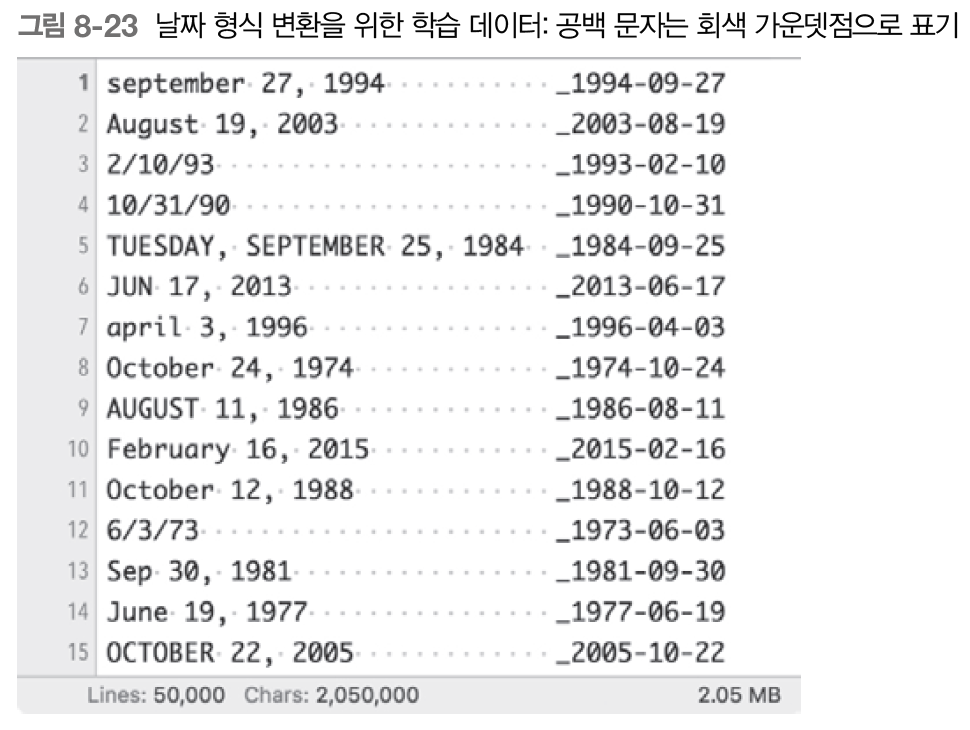

## **어텐션을 갖춘 seq2seq의 학습**

In [17]:
import sys
sys.path.append(path + '/ch07')

import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq, Encoder
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))

model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 12[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 23[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 35[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 46[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 58[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 69[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 81[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 92[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 104[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 116[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 127[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 139[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 151[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 163[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 174[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 186[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 198[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November 

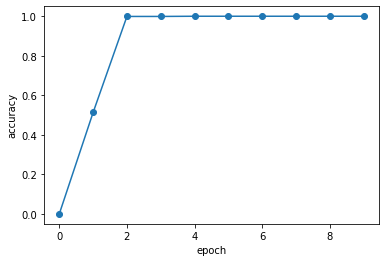

In [20]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

결과를 보면 2에폭째에서부터 거의 모든 문제를 풀어내는 모습을 알 수 있다. 앞장의 baseline, peeky를 적용한 seq2seq과 비교를 해보면 baseline은 전혀 쓸모가 없는 정도임을 알 수 있고, peeky는 attention을 적용한 seq2seq과 비슷하게 학습이 잘 되고 있음을 알 수 있다. 하지만 학습 속도는 어텐션 쪽이 약간 우세하다.

최종 정확도 측면에서는 어텐션과 Peeky가 동등했지만 현실의 시계열 데이터는 길고 복잡하므로, 학습 속도뿐 아니라 정확도 역시 어텐션이 유리할 것이다.

## **어텐션 시각화**

Attention 계층은 각 시각의 어텐션 가중치를 인스턴스 변수로 보관하고 있으므로, 이를 시각화하기란 아주 간단하다. 

Time Attention 계층의 인스턴스 변수에 저장되어 있는 어텐션 가중치를 사용하면 입력 문장과 출력 문장의 단어 대응 관계를 2차원 맵으로 그릴 수 있다.

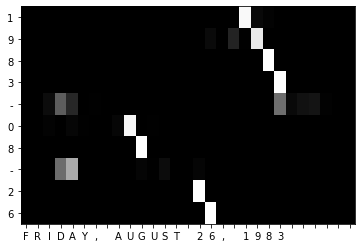

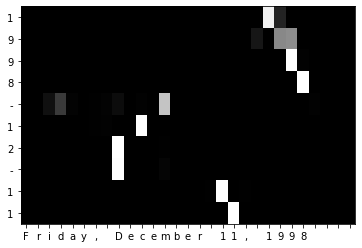

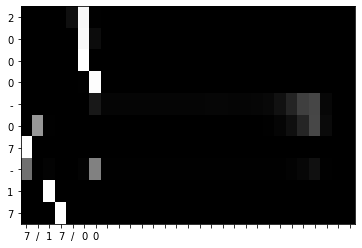

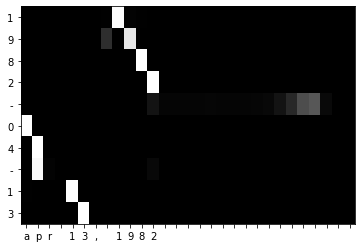

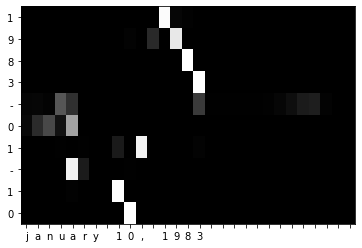

In [19]:
from dataset import sequence
import matplotlib.pyplot as plt
from ch08.attention_seq2seq import AttentionSeq2seq


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

시각화 결과, 월을 뜻하는 "08"에 입력 문장의 "AUGUST"가 대응하고 있는 점은 놀랄만한 일이다. seq2seq는 "August"가 "8월"에 대응한다는 사실을 데이터만 가지고 학습해낸 것이다.

이처럼 어텐션을 이용하면, seq2seq는 마치 사람이 그러하듯 필요한 정보에 주의를 더 기울일 수 있다. "어텐션을 통해, 모델이 수행하는 작업을 우리 인간이 이해할 수 있게 되었다"라고도 생각할 수 있다.

신경망 내부에서 어떠한 처리를 이뤄지고 있는지(어떠한 논리로 처리되고 있는지)는 인간이 이해할 수 없는 게 일반적이다. 반면 어텐션은 '인간이 이해할 수 있는 구조나 의미'를 모델에 제공한다.

# **어텐션엔 관한 남은 이야기**

## **양방향 RNN**

우리는 글을 왼쪽에서 오른쪽으로 읽는다. 따라서 "나" "는" "고양이" "로소" "이다"라는 문장에서 "고양이"에 대응하는 벡터에 "나", "는", "고양이"까지 총 세 단어의 단어의 정보가 인코딩되어 들어간다. 여기에서 전체적인 균형을 생각하면, "고양이" 단어의 '주변' 정보를 균형 있게 담고 싶을 것이다.

따라서 LSTM을 양방향으로 처리하는 방법을 생각할 수 있다. 이것이 **양방향 LSTM(양방향 RNN)** 기술이며, 그림으로는 다음과 같다.

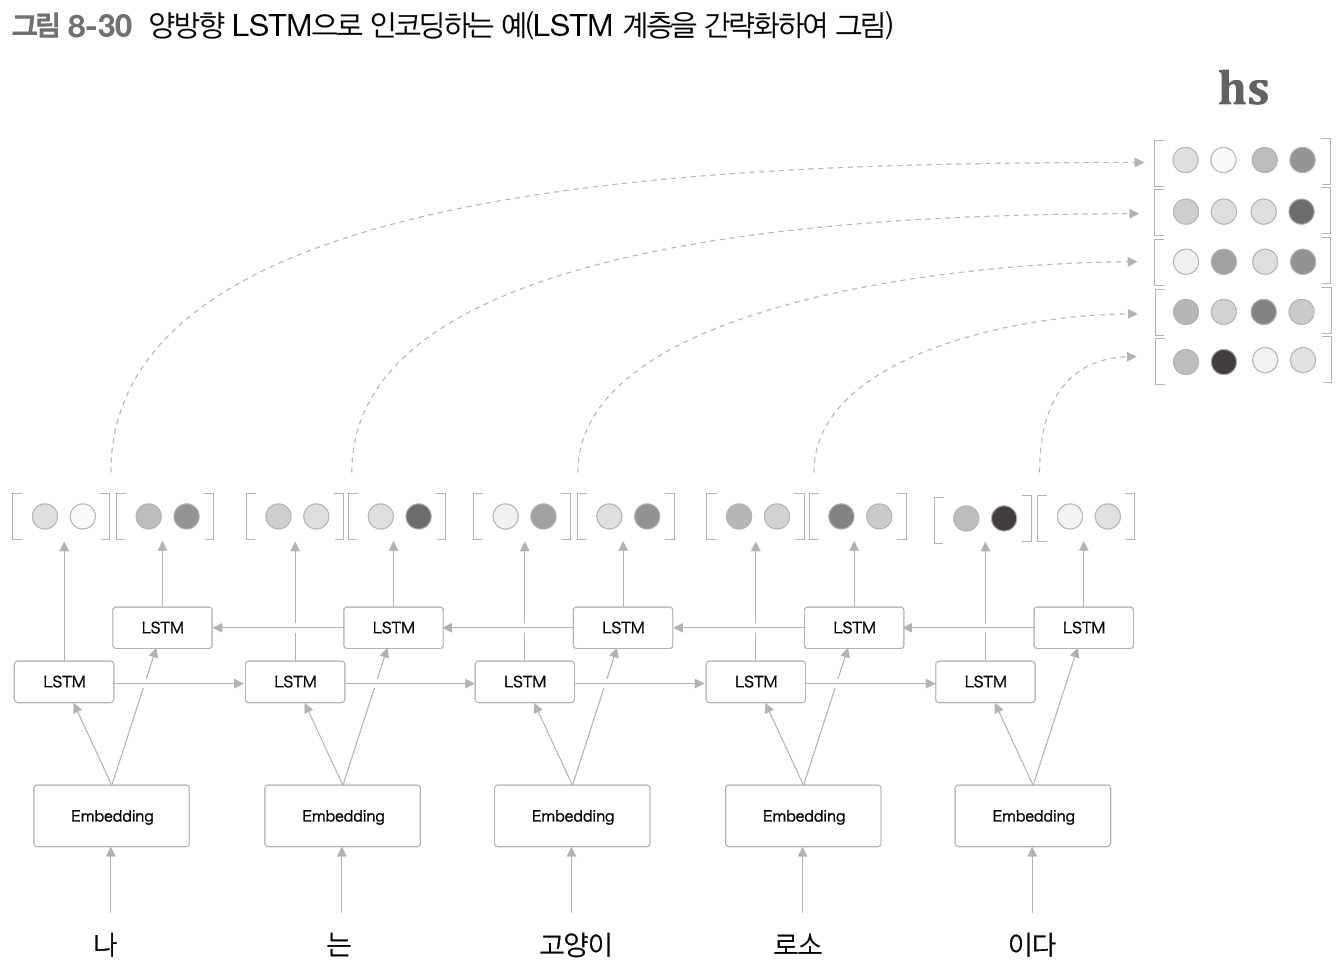

양방향으로 처리함으로써, 각 단어에 대응하는 은닉 상태 벡터에는 좌와 우 양쪽 방향으로부터의 정보를 집약할 수 있다. 이로써 균형 잡힌 정보가 인코딩되게 된다.

## **Attention 계층 사용 방법**

앞 절까지 사용해온 어텐션을 갖춘 seq2seq의 계층 구성에서는, Attention 계층을 LSTM 계층과 Affine 계층 사이에 삽입했지만, Attention 계층을 이용하는 장소가 반드시 그럴 필요는 없다. 예를 들어 다음 그림처럼 구성할 수도 있다.

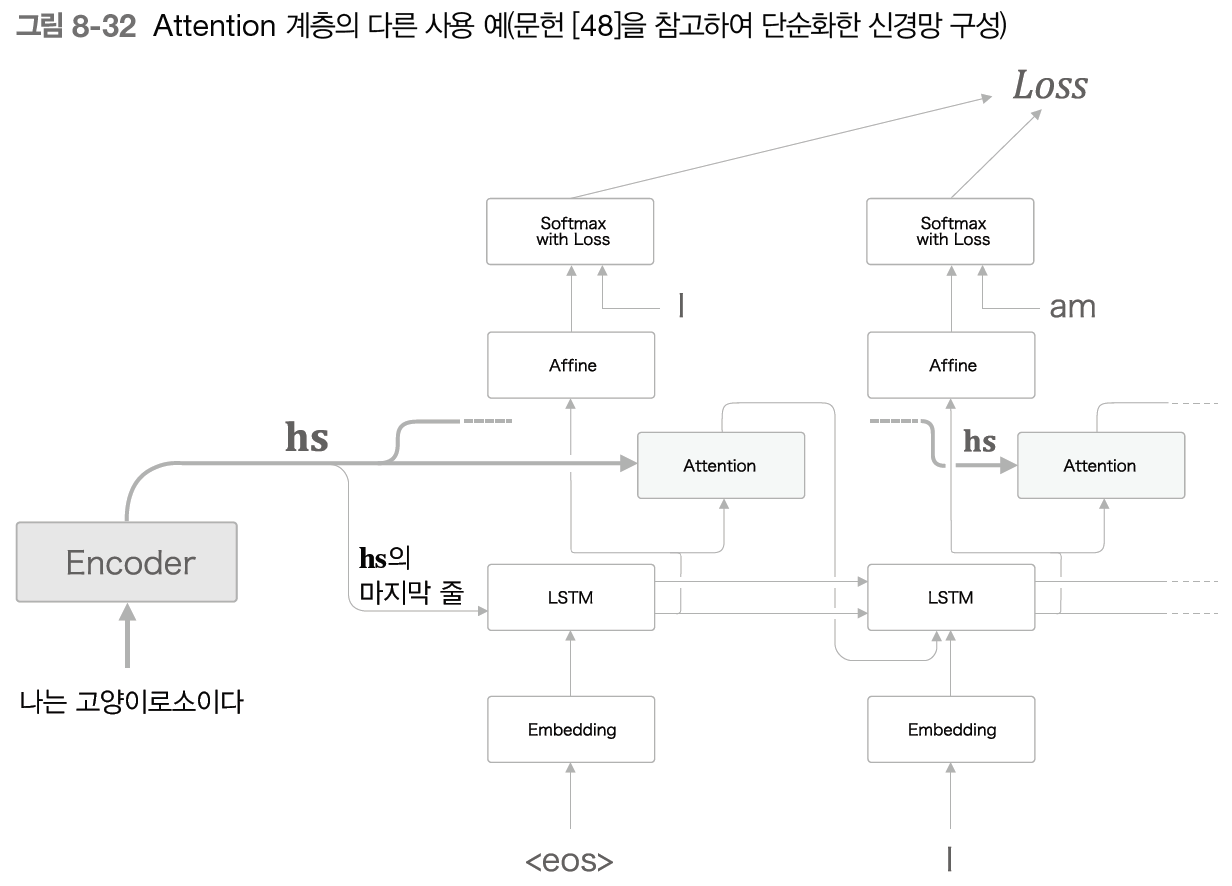

이렇게 구성하면 LSTM 계층이 맥락 벡터의 정보를 이용할 수 있다. 한편, 우리가 구현한 모델은 Affine 계층이 맥락 벡터를 이용했다. 아래는 우리가 구현한 모델이다.

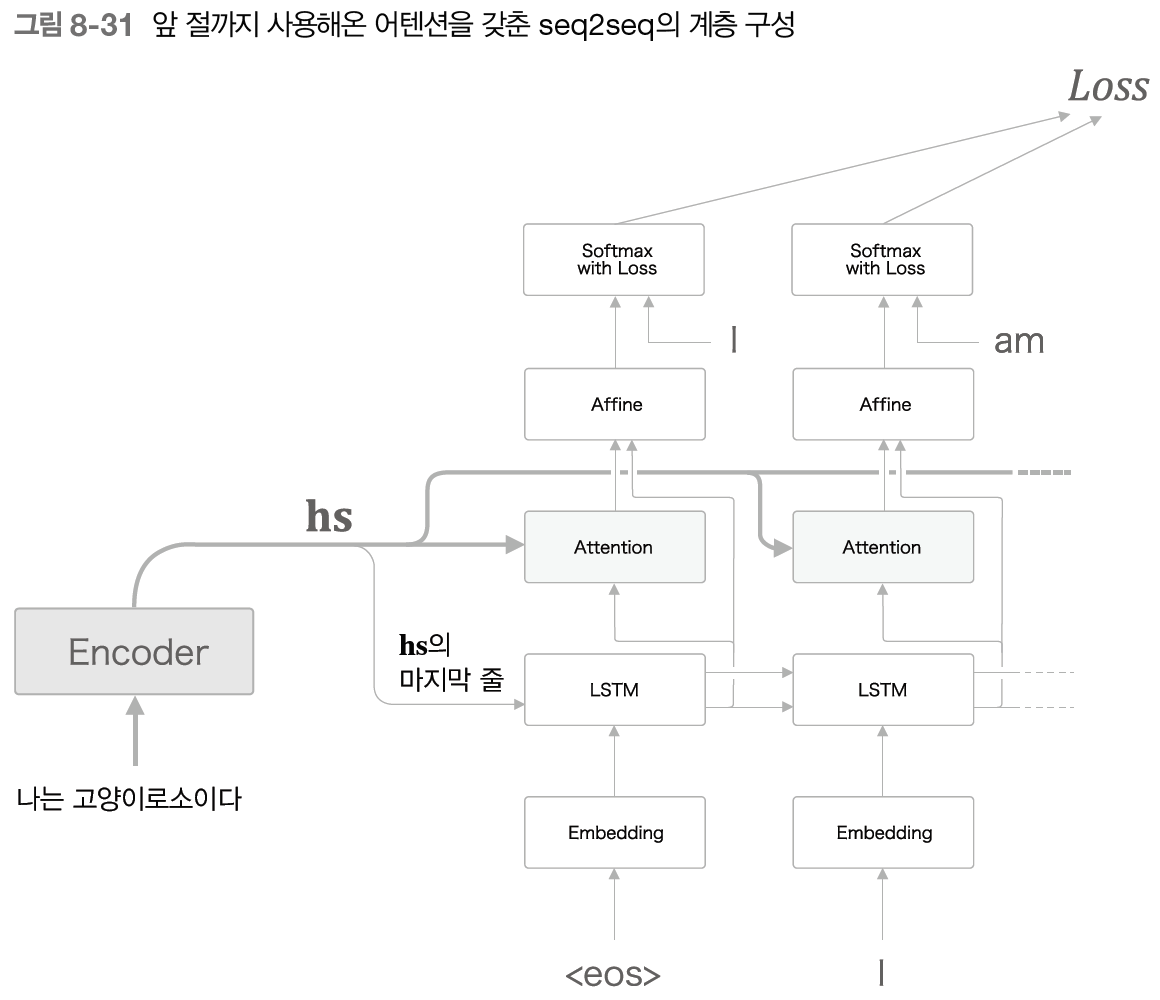

그렇다면 Attention 계층의 위치를 달리하는게 최종 정확도에 어떤 영향이 주는지는 해보지 않고선 모른다. 현실의 데이터를 사용해 검증할 수밖에 없다.

또한 구현 관점에서는 기존의 구성이 구현하기 쉽다. 또한 Decoder의 데이터 흐름이 아래에서 위로 가는 한 방향이기 때문에 Attention 계층을 쉽게 모듈화할 수 있다.

## **seq2seq 심층화와 skip 연결**

번역 등 현실에서의 애플리케이션들은 풀어야 할 문제가 훨씬 복잡하다. 그렇다면 어텐션을 갖춘 seq2seq에도 더 높은 표현력이 요구될 것이다. 이때 우선 생각해야 할 것이 RNN 계층(LSTM 계층)을 깊게 쌓는 방법이다.

층을 깊게 할 때 사용되는 중요한 기법 중 **skip 연결(skip connection)**이라는 것이 있다. ('잔차 연결(residual connection)' 혹은 '숏컷(short-cut)'이라고도 한다). skip 연결을 다음 그림처럼 계층을 넘어 '선을 연결'하는 단순한 기법이다.

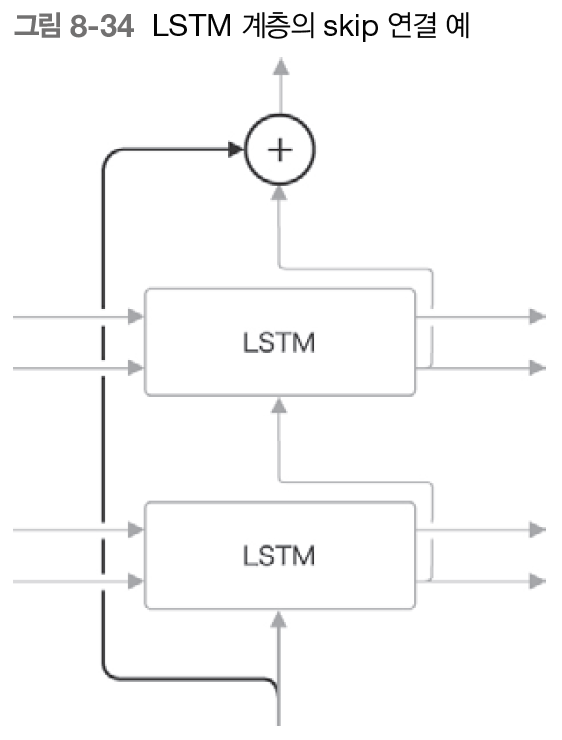

그림에서 보듯, skip 연결은 '계층을 건너뛰는 연결'이다. 이때 skip 연결의 접속부에서는 2개의 출력이 '더해'진다. 이 덧셈(정확하게는 원소별 덧셈)이 핵심이다. 왜냐하면 덧셈은 역전파 시 기울기를 '그대로 흘려'보내므로, skip 연결의 기울기가 아무런 영향을 받지 않고 모든 계층으로 흐르기 때문이다. 따라서 층이 깊어져도 기울기가 소실(혹은 폭발)되지 않고 전파되어, 결과적으로 좋은 학습을 기대할 수 있다.

# **어텐션 응용**

실제로 최근 딥러닝 연구에서는 어텐션이 중요한 기술로써 다양한 장면에서 등장한다. 최첨단 연구 3가지에 대해서 살펴보자.

## **구글 신경망 기계 번역(GNMT)**

기계 번역의 기법은 시대의 흐름과 함께 변해왔다. 그 흐름은 '규칙 기반 번역'에서 '용례 기반 번역'으로, 다시 '통계 기반 번역'으로 옮겨왔다. 현재는 이 기존 기술들을 대신해 **신경망 기계 번역(Neural Machine Translation, NMT)**이 주목받고 있다.

구글 번역(Google Translate)은 실제로 2016년부터 신경망 번역을 사용한다. 이 기계 번역 시스템은 **구글 신경망 기계 번역(Google Neural Machine Translation, GNMT)**이라 한다.

## **트랜스포머**

RNN에도 단점이 있고, 그중 하나로 병렬 처리를 들 수 있다.

RNN은 이전 시각에 계산한 결과를 이용하여 순서대로 계산한다. 따라서 RNN의 계산을 시간 방향으로 병렬 계산하기란 (기본적으로는) 불가능하다. 이 점은 딥러닝 학습이 GPU를 사용한 병렬 계산 환경에서 이뤄진다는 점을 생각하면 큰 문제가 아닐 수 없다.

이러한 배경에서, RNN을 없애는 연구(혹은 병렬 계산할 수 있는 RNN 연구)가 활발히 이뤄지고 있는데, 그 중 유명한 것이 트랜스포머(Transformer) 모델이다. 'RNN이 아닌' 어텐션을 사용해 처리한다.

트랜스포머는 어텐션으로 구성되는데, 그중 **셀프어텐션(Self-Attention)**이라는 기술을 이용하는 게 핵심이다. Self-Attention은 직역하면 '자신에 대한 주목'이다. 즉, 하나의 시계열 데이터를 대상으로 한 어텐션으로, '하나의 시계열 데이터 내에서' 각 원소가 다른 원소들과 어떻게 관련되는지를 살펴보자는 취지이다. 우리의 Time Attention 계층을 예로 설명하면, 셀프 어텐션은 다음과 같다.


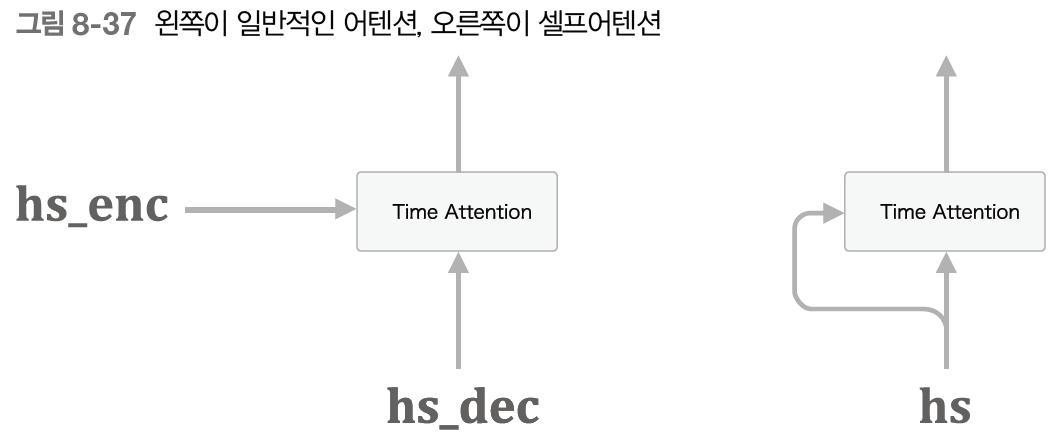

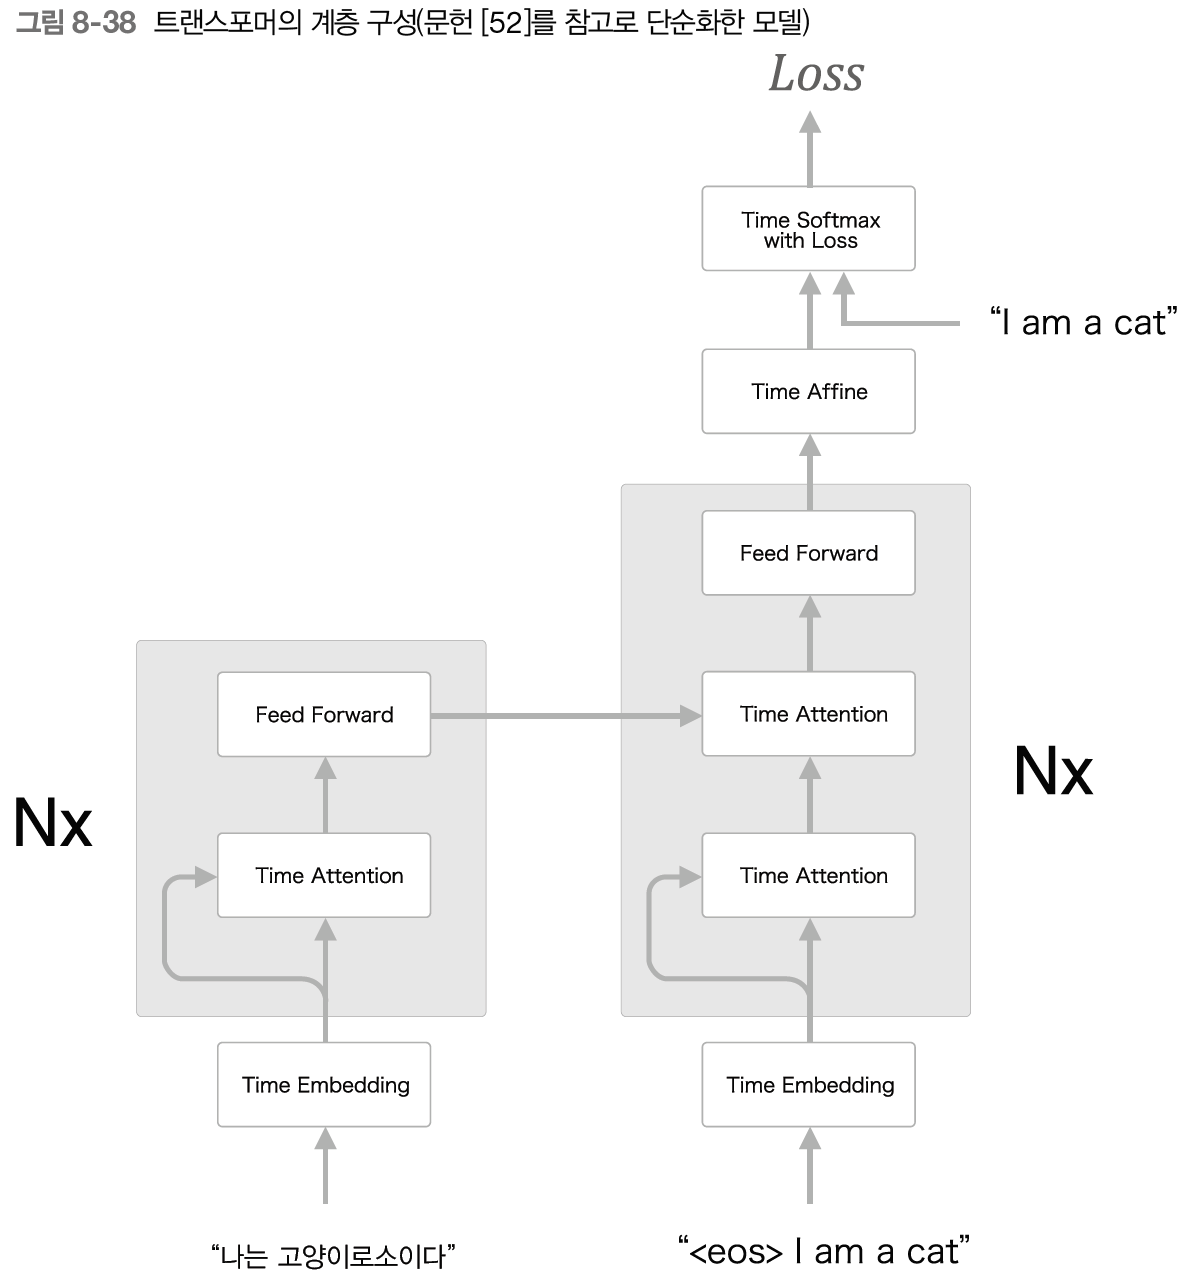

트랜스포머에서는 RNN 대신 어텐션을 사용한다. [그림 8-38]을 보면 Encoder와 Decoder 모두에서 셀프어텐션을 사용함을 알 수 있다. 또한 [그림 8-38]의 Feed Forward 계층은 피드포워드 신경망(시간 방향으로 독립적으로 처리하는 신경망)을 나타낸다. 정확하게는 은닉층이 1개이고 활성화 함수로 ReLU를 이용한 완전연결계층 신경망을 이용한다. 또한, 그림에서 Nx는 회색 배경으로 둘러싸인 계층들을 N겹 쌓았다는 뜻이다.

트랜스포머를 이용하면 계산량을 줄이고 GPU를 이용한 병렬 계산의 혜택도 더 많이 누릴 수 있다. 그 결과 트랜스포머는 GNMT보다 학습 시간을 큰 폭으로 줄이는데 성공했다.

우리는 지금까지 어텐션을 RNN과 조합해 이용해왔다. 그러나 이번 절의 연구가 시사하는것처럼 어텐션은 RNN을 대체하는 모듈로도 이용할 수 있다.

## **뉴럴 튜링 머신(NTM)**

신경망에 '외부 메모리'를 이용하여 새로운 힘을 부여할 수 있다. 이번 절에서 다룰 주제는 바로 '외부 메모리를 통한 확장'이다.

어텐션을 갖춘 seq2seq에서는 Encoder가 입력 문장을 인코딩 한 후, 인코딩된 정보를 어텐션을 통해 Decoder가 이용했다. 여기서 주목할 것은 어텐션의 존재이다.
Encoder가 필요한 정보를 메모리에 쓰고, Decoder는 그 메모리로부터 필요한 정보를 읽어 들인다고 해석할 수 있다.

컴퓨터의 메모리 조작을 신경망에서도 재현할 수 있을 것 같다. 바로 RNN의 외부에 정보 저장용 메모리 기능을 배치하고, 어텐션을 이용하여 그 메모리로부터 필요한 정보를 읽거나 쓰는 방법이다.

이러한 연구 중 유명한 연구가 **뉴럴 튜링 머신(Neural Turing Machine, NTM)**이다.

NTM은 외부 메모리를 읽고 쓰면서 시계열 데이터를 처리한다. 또 하나 재밌는 사실은 이러한 메모리 조작은 '미분 가능'한 계산으로 구축했다는 점이다. 따라서 메모리 조작 순서도 데이터로부터 학습할 수 있다.

일반적인 컴퓨터는 사람의 프로그래밍에 따라 동작하는 데 반해, NTM은 데이터로부터 프로그램을 학습한다. 즉 '알고리즘의 입력과 출력'으로부터 '알고리즘 자체(로직)'를 학습할 수 있다는 뜻이다.

# **정리**

* **번역이나 음성 인식 등, 한 시계열 데이터를 다른 시계열 데이터로 변환하는 작업에서는 시계열 데이터 사이의 대응 관계가 존재하는 경우가 많다.**
* **어텐션은 두 시계열 데이터 사이의 대응 관계를 데이터로부터 학습한다.**
* **어텐션에서는 (하나의 방법으로서) 벡터의 내적을 사용해 벡터 사이의 유사도를 구하고, 그 유사도를 이용한 가중합 벡터가 어텐션의 출력이 된다.**
* **어텐션에서 사용하는 연산은 미분 가능하기 때문에 오차역전파법으로 학습할 수 있다.**
* **어텐션이 산출하는 가중치(확률)를 시각화하면 입출력의 대응 관계를 볼 수 있다.**
* **외부 메모리를 활용한 신경망 확장 연구 예에서는 메모리를 읽고 쓰는 데 어텐션을 사용했다.**